#Is there a wage gap in Mexico?

We took our data set from [INEGI](https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/datosabiertos/2022/conjunto_de_datos_enoen_2022_1t_csv.zip). It contains information about employment corresponding to the first quarter of 2022.

##Data

We begin cleaning our data .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
coe1 = pd.read_csv('/content/drive/MyDrive/albertogtelesforo@ciencias.unam.mx 2022-10-21 18:19/project_1/conjunto_de_datos_enoen_2022_1t_csv/conjunto_de_datos_coe1_enoen_2022_1t/conjunto_de_datos/conjunto_de_datos_coe1_enoen_2022_1t.csv')

In [3]:
coe2 = pd.read_csv('/content/drive/MyDrive/albertogtelesforo@ciencias.unam.mx 2022-10-21 18:19/project_1/conjunto_de_datos_enoen_2022_1t_csv/conjunto_de_datos_coe2_enoen_2022_1t/conjunto_de_datos/conjunto_de_datos_coe2_enoen_2022_1t.csv')

In [ ]:
sdem = pd.read_csv('/content/drive/MyDrive/albertogtelesforo@ciencias.unam.mx 2022-10-21 18:19/project_1/conjunto_de_datos_enoen_2022_1t_csv/conjunto_de_datos_sdem_enoen_2022_1t/conjunto_de_datos/conjunto_de_datos_sdem_enoen_2022_1t.csv',encoding='latin-1')

In [5]:
indices = list(coe1.columns)[1:14]+(list(coe1.columns)[-5:])
coe1_id = coe1.set_index(indices)
coe1_id.columns=coe1_id.columns.str.upper()
coe1_id = coe1_id[['R_DEF','P3','P4A','P4A_1','P4B','P5E_THRS','P5E_TDIA']]

In [6]:
indices = list(coe1.columns)[1:14]+(list(coe1.columns)[-5:])
coe2_id = coe2.set_index(indices)
coe2_id.columns=coe2_id.columns.str.upper()

In [7]:
coe = pd.merge(coe1_id,coe2_id,how='left',right_index=True,left_index=True)
coe = coe[coe['R_DEF']==0]

In [8]:
indices = list(coe1.columns)[1:14]+(list(coe1.columns)[-5:])
sdem.replace(' ',np.nan,inplace=True)
sdem['eda']=sdem['eda'].astype('float')
sdem_id = sdem[sdem['eda']>=12]
sdem_id = sdem_id.set_index(indices)
sdem_id.columns=sdem_id.columns.str.upper()
sdem_id = sdem_id[sdem_id['R_DEF']==0]
sdem_id = sdem_id[['SEX','ZONA']]

In [9]:
df  = pd.merge(coe,sdem_id,how='inner',left_index=True,right_index=True)

In [10]:
df = df[['SEX','ZONA','P3','P5E_THRS','P6_7','P6B1','P6B2']]


In [11]:
dictionary = {'ZONA':'wage_zone','P3':'position','P5E_THRS':'hrs','P6_7':'wage','P6B1':'period','P6B2':'wage_$'}
df = df.rename(columns=dictionary)
#Translation, the data dictionary (diccionario_datos_coe2_enoen_2022_1t.csv) is in the data set I provided
#Zona-In mexico are two wage zones, the north border one, and the rest.
#P3 corresponds to the job position
#P5E_THRS number of working hours in the past week
#P6_7 does the person's income come from wage only (7=yes other option correspond to other variables)
#P6B1 period of payment. Options greater than 5 correspond to non-wage earns
#P6B2 wage per month in mexican pesos 

In [12]:
df = df[df['wage_zone']==2]
df.loc[:,'wage'] = df['wage'].replace(' ',np.nan)
df.loc[:,'wage'] = df['wage'].astype('float')


df.loc[:,'period'] = df['period'].replace(' ',np.nan)
df.loc[:,'period'] = df['period'].astype('float')

##Analysis

We analyze male and female wages separately. We focus on persons whose wage is their total income inasmuch as persons' abilities determine other kind of income (e.g. commision, piecework).

###Mean comparison

In [13]:
male = df[df['SEX']==1]
female = df[df['SEX']==2]

In [14]:
#According to the dictionary, option 7 of 'wage' corresponds to only wage.
male_wage = male[male['wage']==7]
female_wage = female[female['wage']==7]

male_wage  = male_wage.replace(' ',np.nan)
female_wage = female_wage.replace(' ',np.nan)

male_wage.loc[:,'wage_$'] = male_wage['wage_$'].astype('float')
female_wage.loc[:,'wage_$'] = female_wage['wage_$'].astype('float')

xy_wage = male_wage[['position','hrs','period','wage_$']]

#period < 5 corresponds to wage only income
xy_wage = xy_wage[xy_wage['period']<5]

xx_wage = female_wage[['position','hrs','period','wage_$']]

xx_wage = xx_wage[xx_wage['period']<5]

#calculate mean, std and yerr
xy_mean = xy_wage['wage_$'].mean()
xx_mean = xx_wage['wage_$'].mean()

xy_std = male_wage['wage_$'].std()
xx_std = female_wage['wage_$'].std()

xx_mean,xy_mean

(7085.311805775944, 8309.534739738592)

###We need further analysis.

Consider the following.

1. The above comparison does not tell us whether there is a wage gap: a janitor earns less than a college teacher. It could be the case that women have jobs with a lower wage mean. Thus, we need to compare wages according to position. Inasmuch as grouping by position will give us a collective mean, we must drop all person with no income data; otherwise our estimation could be really far from the real data.



2. The wage per position analysis is not enough. We must compare the wage per hour in the same position. And we must be careful, if we have no work-day data for some person, we cannot take her into account. This is because even when we have her position and income, if we do not have her work-day data, we are not able to calculate her income per hour. 


3. With the above consideration we are obliged to drop almost all our data. The positions for which we have enough data to compare wages are: College Prof, Secondary School Prof, Elementary School Prof,Aux Business Admin, Aux General Admin, Salesperson and Janitor. Confidence intervals for them are too big, this means that we cannot say that in fact there is a wage gap: the lower limit of men is lower than the upper limit for women. If those are the real values, the gap exists but it is in detriment to men. The conclusion is that we have not enough information to conclude there is a wage gap.


4.  INEGI has done an analysis with smaller confidence intervals, however it is done by job sector. So, it does not imply that there is a wage gap because a wage gap exists if a man in the same position that a woman earns more per hour. Grouping by job sector does not indicate that this is the case.

Understanding wage gap as the condition where men earn per hour more than women in the same position, we cannot tell there is a wage gap. We need more data for each position.


###Plot

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


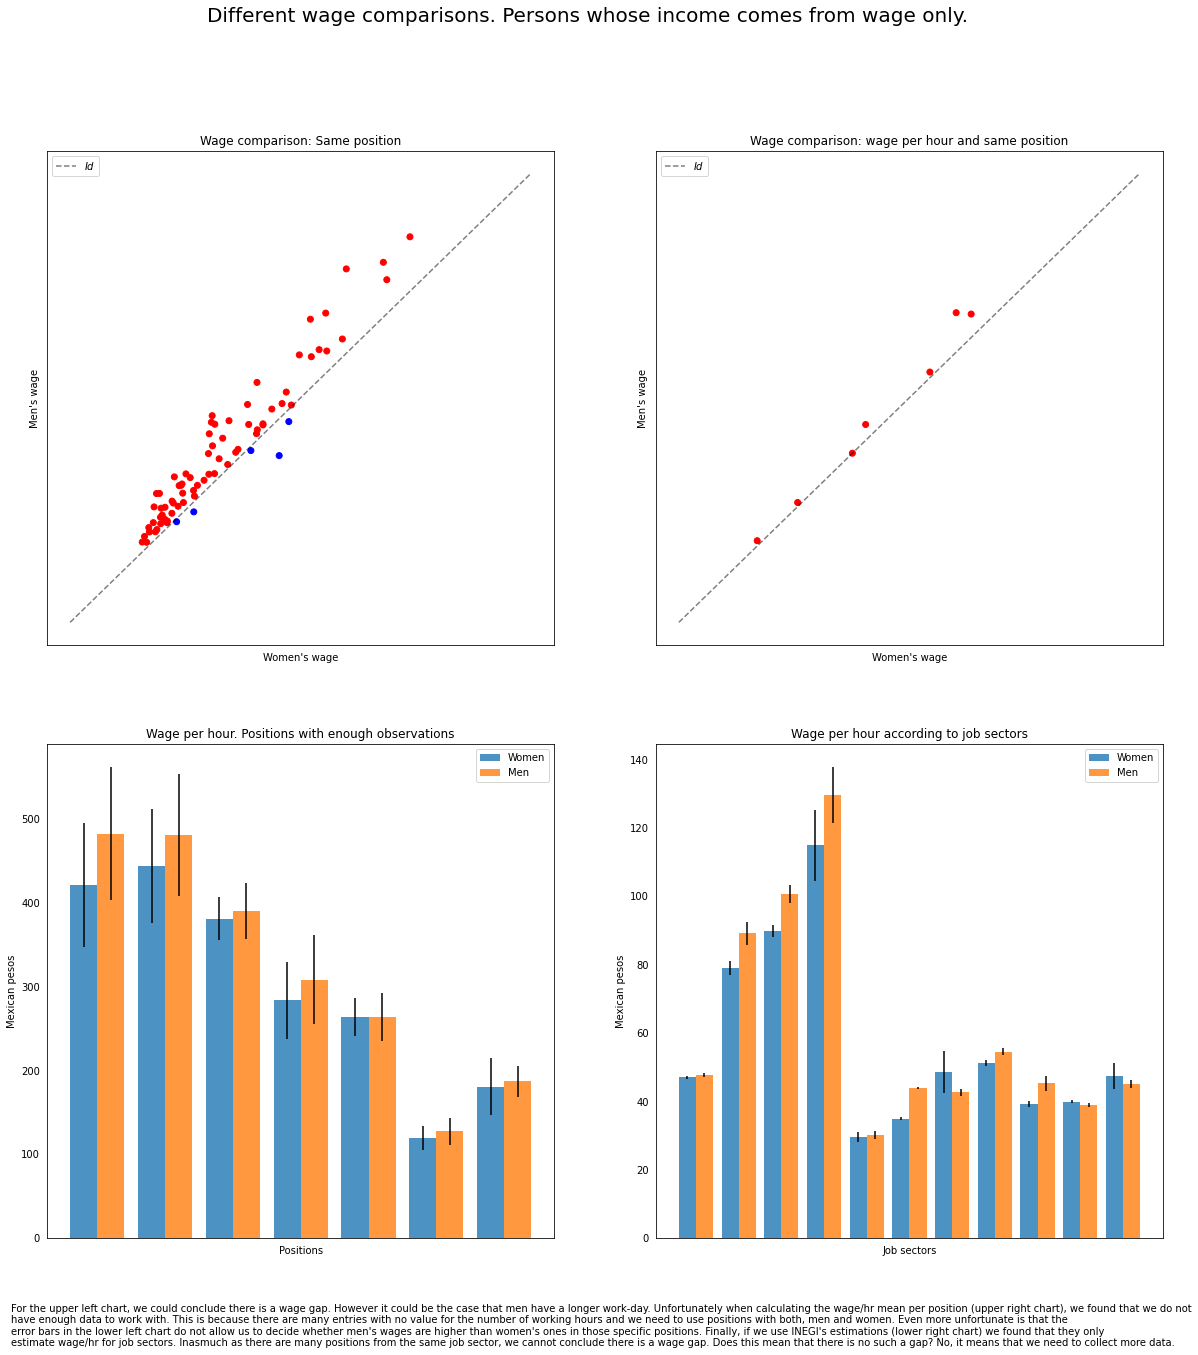

In [15]:
plt.figure(figsize=(20,20))
plt.suptitle('Different wage comparisons. Persons whose income comes from wage only.',size=20)

#we drop nan 
male_wage = male_wage[male_wage['wage_$']>0]
female_wage = female_wage[female_wage['wage_$']>0]

#group by position
xy_pos = male_wage.groupby('position')
xy_pos_mean = xy_pos.agg({'wage_$':np.mean})
xy_pos_mean.loc[:,'size'] = xy_pos.size()

xx_pos = female_wage.groupby('position')
xx_pos_mean = xx_pos.agg({'wage_$':np.mean})
xx_pos_mean.loc[:,'size'] = xx_pos.size()

#drop groups with not enough members
xx_pos_mean = xx_pos_mean[xx_pos_mean['size']>30]
xy_pos_mean = xy_pos_mean[xy_pos_mean['size']>30]

#if we are looking for gender gap, we must compare positions with
#both, men and women
positions_both = pd.merge(xx_pos_mean['wage_$'],xy_pos_mean['wage_$'],how='inner',left_index=True,right_index=True)


positions_both.loc[:,'quotient'] = positions_both['wage_$_x']/positions_both['wage_$_y']

colors = []
male_high = 0
female_high = 0
for x in positions_both.index:
  if positions_both.loc[x,'quotient']>1:
    colors.append('blue')
    female_high+=1
  else:
    colors.append('red')
    male_high+=1

#first subplot
plt.subplot(2,2,1)
plt.scatter(positions_both['wage_$_x'],positions_both['wage_$_y'],color=colors)
plt.plot(range(25000),'--',color='black',alpha=.5,label='$Id$')

plt.legend(loc='upper left')
plt.xlabel('Women\'s wage')
plt.ylabel('Men\'s wage')
plt.title('Wage comparison: Same position')

plt.yticks(ticks=[])
plt.xticks(ticks=[])


#second subplot
plt.subplot(2,2,2)
#we drop nan
male_wage.loc[:,'hrs'] = male_wage['hrs'].replace(' ',np.nan)
male_wage['hrs_f'] = male_wage['hrs'].astype('float')

male_wage = male_wage[male_wage['hrs_f']>0]

female_wage.loc[:,'hrs'] = female_wage['hrs'].replace(' ',np.nan)
female_wage['hrs_f'] = female_wage['hrs'].astype('float')

female_wage = female_wage[female_wage['hrs_f']>0]

#calculate wage/hr
male_wage.loc[:,'wage/hr'] = male_wage['wage_$']/male_wage['hrs_f']
xy_pos_hrs = male_wage.groupby('position')
xy_pos_hrs_mean = xy_pos_hrs.agg({'wage/hr':np.nanmean})
xy_pos_hrs_mean.loc[:,'size'] = xy_pos_hrs.size()
xy_pos_hrs_mean.loc[:,'std'] = xy_pos_hrs.agg({'wage/hr':np.nanstd})

female_wage.loc[:,'wage/hr'] = female_wage['wage_$']/female_wage['hrs_f']
xx_pos_hrs = female_wage.groupby('position')
xx_pos_hrs_mean = xx_pos_hrs.agg({'wage/hr':np.nanmean})
xx_pos_hrs_mean.loc[:,'size'] = xx_pos_hrs.size()
xx_pos_hrs_mean.loc[:,'std'] = xx_pos_hrs.agg({'wage/hr':np.nanstd})

#drop little groups
xx_pos_hrs_mean = xx_pos_hrs_mean[xx_pos_hrs_mean['size']>30]
xy_pos_hrs_mean = xy_pos_hrs_mean[xy_pos_hrs_mean['size']>30]

#again we inner merge 
both = pd.merge(xx_pos_hrs_mean[['wage/hr','std','size']],xy_pos_hrs_mean[['wage/hr','std','size']],how='inner',left_index=True,right_index=True)

both.loc[:,'quotient'] = both['wage/hr_x']/both['wage/hr_y']

colors = []
male_high = 0
female_high = 0
for x in both.index:
  if both.loc[x,'quotient']>1:
    colors.append('blue')
    female_high+=1
  else:
    colors.append('red')
    male_high+=1
plt.scatter(both['wage/hr_x'],both['wage/hr_y'],color=colors)
plt.plot(range(700),'--',color='black',alpha=.5,label='$Id$')
plt.legend(loc='upper left')
plt.xlabel('Women\'s wage')
plt.ylabel('Men\'s wage')
plt.title('Wage comparison: wage per hour and same position')

plt.yticks(ticks=[])
plt.xticks(ticks=[])


#third subplot
plt.subplot(2,2,3)
xy_yerror = 1.96*both['std_y']/np.sqrt(both['size_y'])
xx_yerror = 1.96*both['std_x']/np.sqrt(both['size_x'])

plt.bar(np.arange(7),both['wage/hr_x'],width=.4,yerr=xx_yerror,alpha=.8)
plt.bar(np.arange(7)+.4,both['wage/hr_y'],width=.4,yerr=xy_yerror,alpha=.8)
plt.legend(['Women','Men'])

plt.xticks(ticks=[])
plt.tick_params(left=False)
plt.ylabel('Mexican pesos')
plt.xlabel('Positions')
plt.title('Wage per hour. Positions with enough observations')

#fourth subplot
plt.subplot(2,2,4)

xls = pd.read_excel('/content/drive/MyDrive/albertogtelesforo@ciencias.unam.mx 2022-10-21 18:19/project_1/enoe_n_indicadores_genero_2022_trim1.xlsx',skiprows=64,nrows=11)
xls = xls[['Unnamed: 3','Unnamed: 7','Unnamed: 8','Unnamed: 13','Unnamed: 14']]
xls = xls.rename(columns={'Unnamed: 3':'job sector','Unnamed: 7':'men','Unnamed: 8':'women','Unnamed: 13':'men_se','Unnamed: 14':'women_se'})

plt.bar(np.arange(11),xls['women'],width=.4,yerr=xls['women_se'],alpha=.8)
plt.bar(np.arange(11)+.4,xls['men'],width=.4,yerr=xls['men_se'],alpha=.8)
plt.legend(['Women','Men'])

plt.xticks(ticks=[])
plt.tick_params(left=False)
plt.ylabel('Mexican pesos')
plt.xlabel('Job sectors')
plt.title('Wage per hour according to job sectors')

caption = '''For the upper left chart, we could conclude there is a wage gap. However it could be the case that men have a longer work-day. Unfortunately when calculating the wage/hr mean per position (upper right chart), we found that we do not
have enough data to work with. This is because there are many entries with no value for the number of working hours and we need to use positions with both, men and women. Even more unfortunate is that the 
error bars in the lower left chart do not allow us to decide whether men's wages are higher than women's ones in those specific positions. Finally, if we use INEGI's estimations (lower right chart) we found that they only 
estimate wage/hr for job sectors. Inasmuch as there are many positions from the same job sector, we cannot conclude there is a wage gap. Does this mean that there is no such a gap? No, it means that we need to collect more data.'''
plt.figtext(0.1,0.05,caption)
            
plt.savefig('wage.pdf',format='pdf')
plt.savefig('wage.svg',format='svg')
